In [1]:
#plots for sample QC stratified by superpopulation
#variants filtered on DP (>20), GQ (>20) and VAF (>0.25) prior to sample QC to remove false positive SNPs
import hail as hl
import pyspark
from hail.plot import show
from bokeh.plotting import output_file, save
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

hl.plot.output_notebook()

sc = pyspark.SparkContext()
tmp_dir = "hdfs://spark-master:9820/"
lustre_dir = "file:///lustre/scratch123/qc/"
plot_dir = "/lustre/scratch123/qc/plots/"

hl.init(sc=sc, tmp_dir=tmp_dir, default_reference="GRCh38")

Loading BokehJS ...

2022-04-12 09:54:51 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/backend/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/backend/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2
SparkUI available at http://spark-master:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.88-7d39379870da
LOGGING: writing to /home/ubuntu/jupyter/hail-20220412-0954-0.2.88-7d39379870da.log


In [2]:
ht_sample_qc_file = lustre_dir + "matrixtables/mt_pops_sampleqc.ht"
ht = hl.read_table(ht_sample_qc_file)
ht.show()

+-------------------+---------+---------------------+--------------+
| s                 | batch   | sequencing_location | assigned_pop |
+-------------------+---------+---------------------+--------------+
| str               | str     | str                 | str          |
+-------------------+---------+---------------------+--------------+
| "EGAN00003143328" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143329" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143330" | "38268" | "Sanger"            | "AFR"        |
| "EGAN00003143331" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143334" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143336" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143337" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143338" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143339" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143340" | "38268" | "Sanger"            | "EUR"        |
+-------------------+---------+---------------------+--------------+

+-------------------------+--------------------------+------------------------+
| sample_qc.dp_stats.mean | sample_qc.dp_stats.stdev | sample_qc.dp_stats.min |
+-------------------------+--------------------------+------------------------+
|                 float64 |                  float64 |                float64 |
+-------------------------+--------------------------+------------------------+
|                3.59e+01 |                 1.38e+01 |               2.10e+01 |
|                3.50e+01 |                 1.12e+01 |               2.10e+01 |
|                3.54e+01 |                 1.16e+01 |               2.10e+01 |
|                3.56e+01 |                 1.27e+01 |               2.10e+01 |
|                3.51e+01 |                 1.08e+01 |               2.10e+01 |
|                3.55e+01 |                 1.24e+01 |               2.10e+01 |
|                3.62e+01 |                 1.49e+01 |               2.10e+01 |
|                3.51e+01 |                 1.19e+01 |               2.10e+01 |
|                3.56e+01 |                 1.23e+01 |               2.10e+01 |
|                3.54e+01 |                 1.20e+01 |               2.10e+01 |
+-------------------------+--------------------------+------------------------+

+------------------------+-------------------------+--------------------------+
| sample_qc.dp_stats.max | sample_qc.gq_stats.mean | sample_qc.gq_stats.stdev |
+------------------------+-------------------------+--------------------------+
|                float64 |                 float64 |                  float64 |
+------------------------+-------------------------+--------------------------+
|               1.32e+03 |                8.52e+01 |                 1.56e+01 |
|               1.04e+03 |                8.40e+01 |                 1.62e+01 |
|               1.30e+03 |                8.44e+01 |                 1.61e+01 |
|               1.01e+03 |                8.48e+01 |                 1.59e+01 |
|               1.01e+03 |                8.41e+01 |                 1.62e+01 |
|               1.00e+03 |                8.45e+01 |                 1.60e+01 |
|               1.53e+03 |                8.54e+01 |                 1.55e+01 |
|               1.10e+03 |                8.41e+01 |                 1.61e+01 |
|               1.17e+03 |                8.47e+01 |                 1.58e+01 |
|               1.16e+03 |                8.46e+01 |                 1.59e+01 |
+------------------------+-------------------------+--------------------------+

+------------------------+------------------------+---------------------+
| sample_qc.gq_stats.min | sample_qc.gq_stats.max | sample_qc.call_rate |
+------------------------+------------------------+---------------------+
|                float64 |                float64 |             float64 |
+------------------------+-----------

In [3]:
#scatter plot of nSNP vs rTi/Tv to check that adding the high nSNP samples back in wasn't a mistake - seems OK so proceeed
p = hl.plot.scatter(ht.sample_qc.n_snp, ht.sample_qc.r_ti_tv, xlabel='nSNP', ylabel='Ti/Tv ratio', label=ht.batch, collect_all = True)
show(p)

In [5]:
#look at pass/fail per pop for each metric
annot_tsv = lustre_dir + "annotations/sample_qc_by_pop.tsv.bgz"
df = pd.read_csv(annot_tsv, compression="gzip",sep="\t")
df['batch'] = df['batch'].astype(str)
df.head()

,s,batch,sequencing_location,assigned_pop,sample_qc,fail_heterozygosity_rate,fail_n_snp,fail_r_ti_tv,fail_n_transition,fail_n_transversion,fail_r_insertion_deletion,fail_n_insertion,fail_n_deletion,fail_r_het_hom_var,qc_metrics_filters
0,EGAN00003143328,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":35.88350520641446,""stdev"":...",False,False,False,False,False,False,False,False,False,[]
1,EGAN00003143329,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":34.9981589796809,""stdev"":1...",False,False,False,False,False,False,False,False,False,[]
2,EGAN00003143330,38268.0,Sanger,AFR,"{""dp_stats"":{""mean"":35.399220303844835,""stdev""...",False,False,False,False,False,False,False,False,False,[]
3,EGAN00003143331,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":35.60963475440693,""stdev"":...",False,False,False,False,False,False,False,False,False,[]
4,EGAN00003143334,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":35.076327330274616,""stdev""...",False,False,False,False,False,False,False,False,False,[]


In [6]:
df.groupby("assigned_pop")["fail_heterozygosity_rate"].value_counts()

assigned_pop  fail_heterozygosity_rate
AFR           False                         196
              True                            6
AMR           False                           9
              True                            1
EAS           False                          19
EUR           False                       14481
              True                           25
SAS           False                          85
              True                            2
oth           False                         145
              True                            4
Name: fail_heterozygosity_rate, dtype: int64

In [8]:
df.groupby("assigned_pop")["qc_metrics_filters"].value_counts()

assigned_pop  qc_metrics_filters                                                                                                                         
AFR           []                                                                                                                                               195
              ["heterozygosity_rate"]                                                                                                                            6
              ["n_transition","n_transversion","n_deletion","n_snp","n_insertion"]                                                                               1
AMR           []                                                                                                                                                 8
              ["heterozygosity_rate"]                                                                                                                            1
              ["n_snp","n_trans

In [11]:
def plot_fails_by_pop(metric, label):
    #prepare data for seaborn plot
    #unstack fills in missing values, then convert to string for axis labels
    xnames = df.groupby("assigned_pop")[metric].value_counts().unstack(fill_value=0).stack().index.tolist()
    xnames = [str(x).replace("'", "").replace(',', '').replace('(', '').replace(')', '').replace('False', 'Pass').replace('True', 'Fail') for x in xnames]

    #values for Y - normalised counts
    yvals = df.groupby("assigned_pop")[metric].value_counts(normalize=True).unstack(fill_value=0).stack()*100

    a4_dims = (16.69,8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.xticks(rotation=70)

    ping=sns.barplot(x=xnames, y=yvals)
    plottitle = "Percentage of samples passing/failing " + label +  " filter"
    ax.set(xlabel='Population code, pass/fail', ylabel='Percentage of samples', title=plottitle)
    for p in ping.patches:
        ping.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    plotfile = plot_dir + "/sample_qc/" + metric + "_sample_qc_by_pop_filtered.png"
    ping.figure.savefig(plotfile)
    

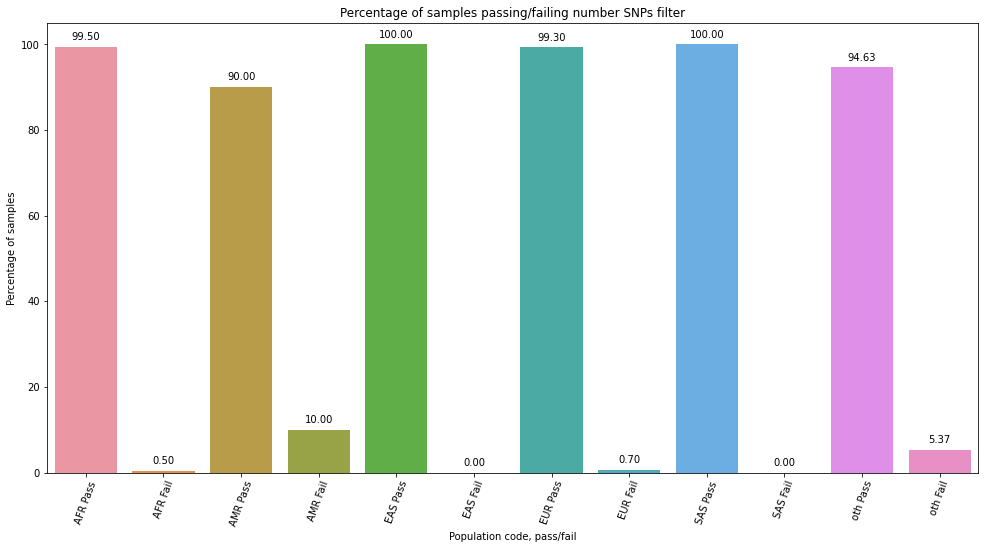

In [13]:
plot_fails_by_pop("fail_n_snp", "number SNPs")

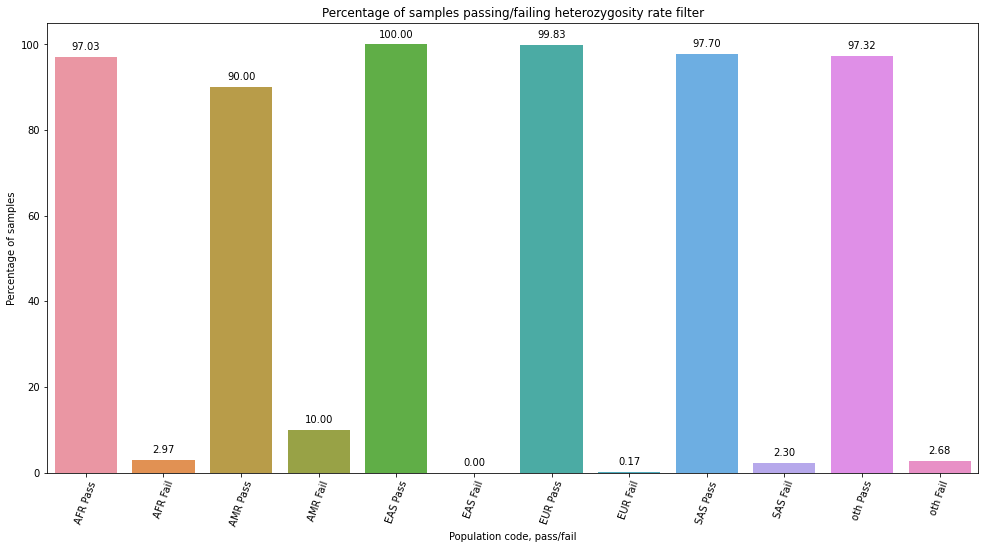

In [14]:
plot_fails_by_pop("fail_heterozygosity_rate", "heterozygosity rate")

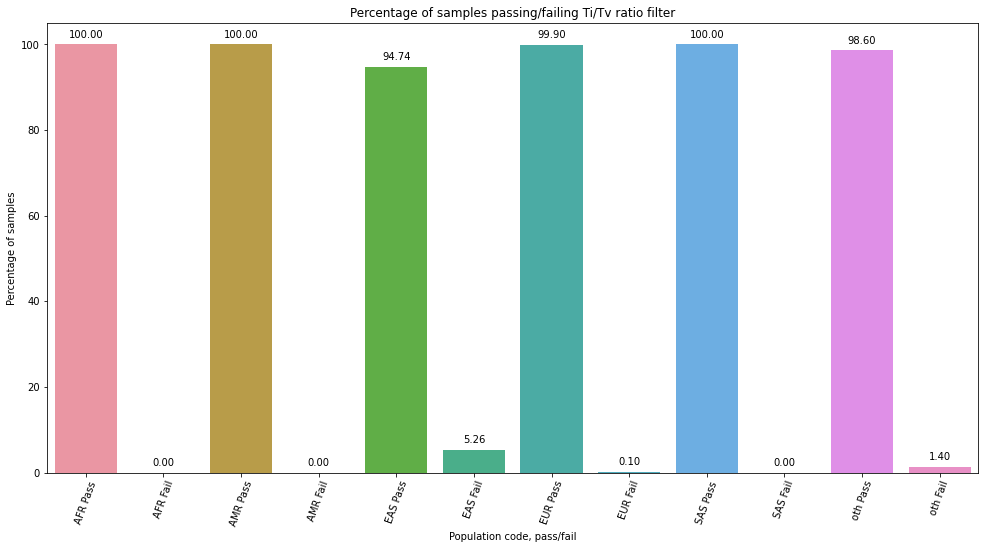

In [15]:
plot_fails_by_pop("fail_r_ti_tv", "Ti/Tv ratio")

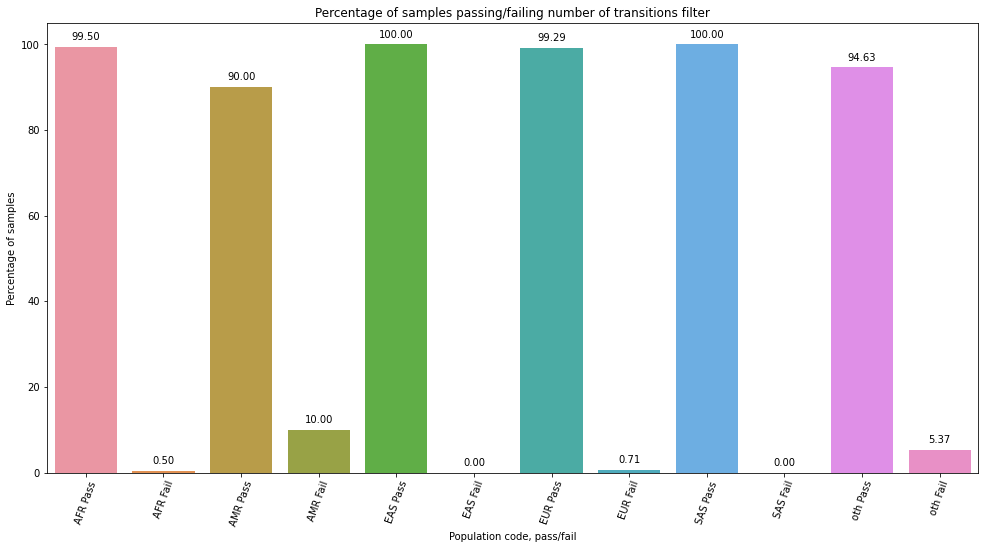

In [16]:
plot_fails_by_pop("fail_n_transition", "number of transitions")

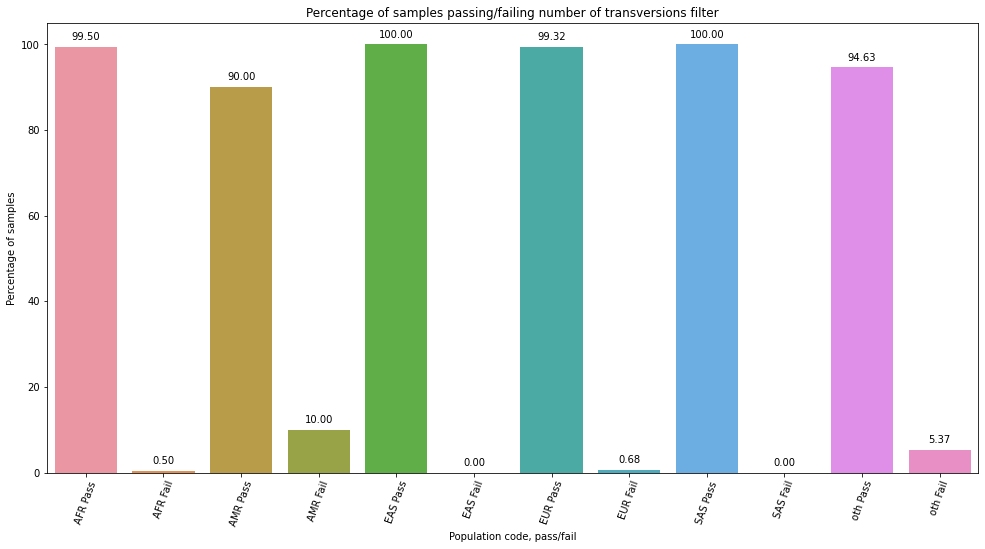

In [17]:
plot_fails_by_pop("fail_n_transversion", "number of transversions")

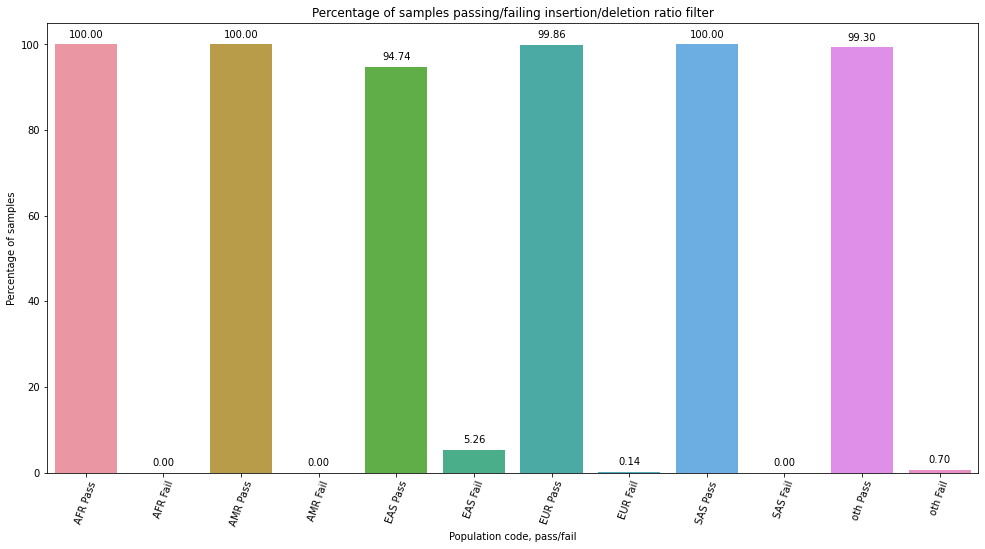

In [18]:
plot_fails_by_pop("fail_r_insertion_deletion", "insertion/deletion ratio")

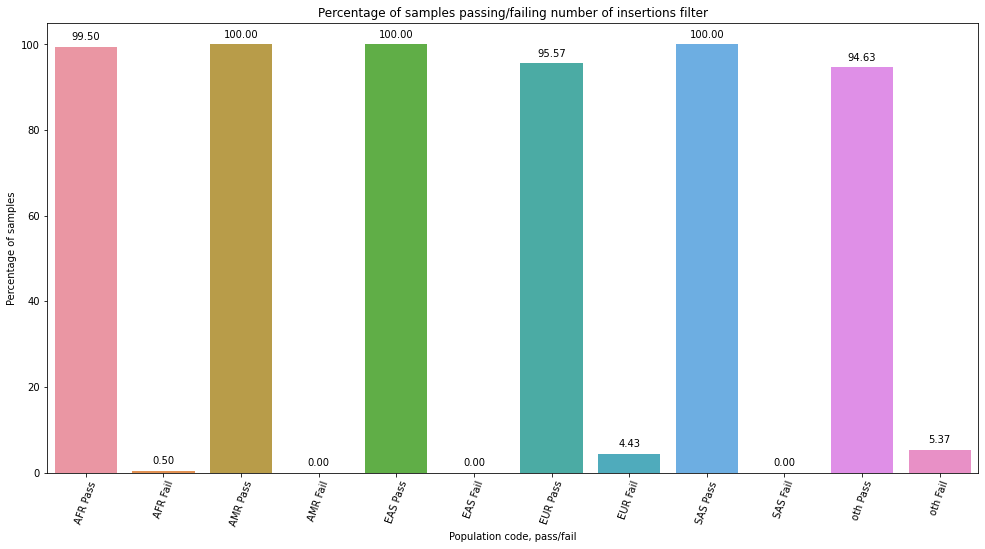

In [19]:
plot_fails_by_pop("fail_n_insertion", "number of insertions")

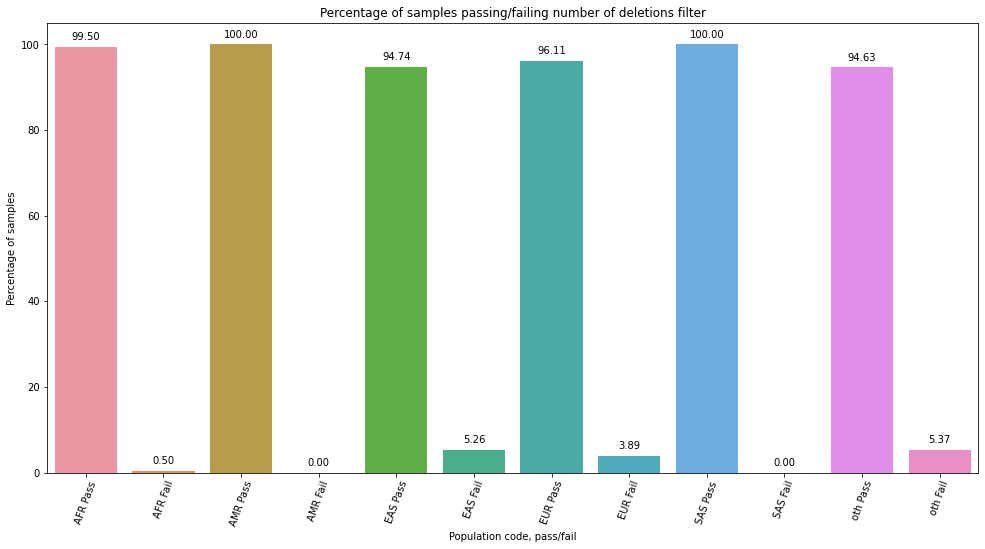

In [20]:
plot_fails_by_pop("fail_n_deletion", "number of deletions")

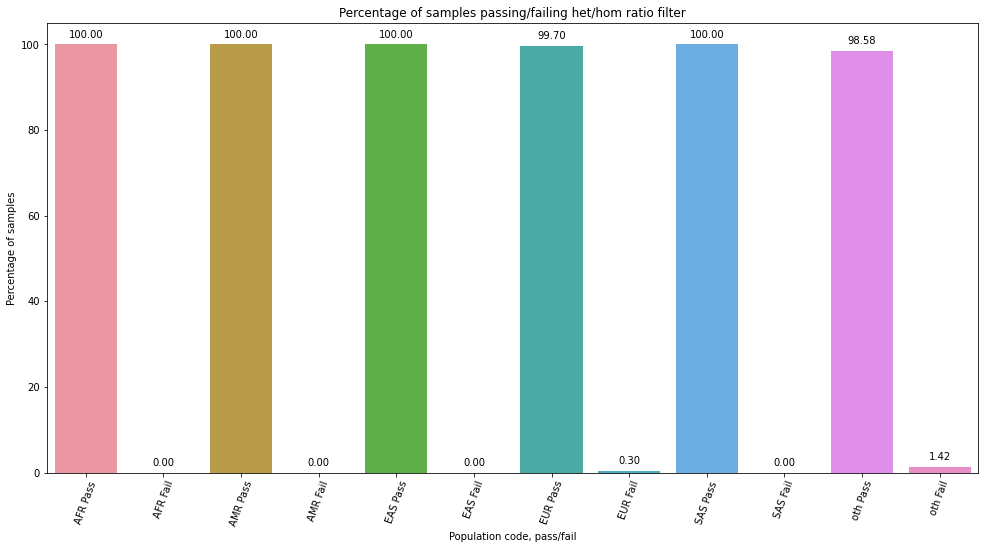

In [21]:
plot_fails_by_pop("fail_r_het_hom_var", "het/hom ratio")